In [1]:
import pandas as pd
import nltk
import sklearn
import textblob
from textblob import TextBlob
import matplotlib
import seaborn

In [2]:
dataset=pd.read_csv("D:/psychatric symptom detection data/tweetss.csv",encoding="latin-1")

In [3]:
dataset.head()

,tweets,Sex,symptom,type,Level
0,Do You Think You Might Be Going Insane Again?,1,1,1,Severe
1,The Day My Heart Broke  Part Two,1,1,3,Severe
2,New #blog post alert! I discuss depression and...,1,1,3,Severe
3,Bipolar Disorder  My Super Power,1,1,2,Severe
4,Finally its Christmas drink season @starbucks...,1,0,0,None


In [4]:
dataset['tweets']=dataset.tweets.astype(str)

In [5]:
dataset['polarity']=dataset['tweets'].apply(lambda tweet:TextBlob(tweet).sentiment.polarity)

In [6]:
dataset['subjectivity']=dataset['tweets'].apply(lambda tweet:TextBlob(tweet).sentiment.subjectivity)


In [7]:
dataset.head()

,tweets,Sex,symptom,type,Level,polarity,subjectivity
0,Do You Think You Might Be Going Insane Again?,1,1,1,Severe,-1.000000,1.000000
1,The Day My Heart Broke  Part Two,1,1,3,Severe,0.000000,0.000000
2,New #blog post alert! I discuss depression and...,1,1,3,Severe,-0.132792,0.622078
3,Bipolar Disorder  My Super Power,1,1,2,Severe,0.333333,0.666667
4,Finally its Christmas drink season @starbucks...,1,0,0,None,0.000000,1.000000


In [8]:
#import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.style.use('ggplot')
from subprocess import check_output
from nltk.tokenize import ToktokTokenizer
toktok=ToktokTokenizer()

In [9]:
### Split Dataset into Train and Text
from sklearn.model_selection import train_test_split
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
df=dataset
df.head()
df.tail()

,tweets,Sex,symptom,type,Level,polarity,subjectivity
3994,I guess I'm gonna travel. Just fearful (very f...,1,1,2,Severe,-0.680000,0.773333
3995,RT @halsey : No jokes right now. I have dedica...,1,1,2,Severe,0.142857,0.417857
3996,Do yourselves a favor... dont EVER date a per...,1,1,2,Severe,0.468750,0.800000
3997,"@LCNSB_ I'm sorry, because I suffer from sever...",1,1,2,Severe,-0.400000,0.638889
3998,RT @StrugglingAnon_ : Honestly I am so fucking...,1,1,2,Highly severe,0.200000,0.500000


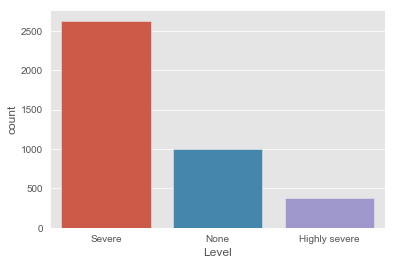

In [11]:
# Value Count 
sns.countplot(df['Level'])

In [12]:
import re
def initial_clean(tweets):
    """
    Function to clear text of websites,email addresses and any punctuation
    We also lower case the text
    """
    tweets=re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)"," ",tweets)
    tweets=re.sub("[^a-zA-Z]"," ",tweets)
    tweets=tweets.lower()
    #text=nltk.word_tokenize(text)
    tweets=toktok.tokenize(tweets)
    return tweets
#stop_words=stopwords.words('english')
'''
def remove_stop_words(tweets):
    
    Function that removes all stopwords from text
    
    return [word for word in message if word not in stop_words] '''
stemmer=PorterStemmer()
def stem_words(tweets):  
    '''
    Function to stem words so that plural and singular are treated the same
    '''
    try:
        tweets=[stemmer.stem(word) for word in tweets]
        tweets=[word for word in tweets if len(word)>1] #make sure we have no 1 letter words
    except IndexError: #the word 'oed' broke this,so needed try except
        pass
    return tweets
def apply_all(tweets):
    '''
    This function applies all the function above into one  remove_stop_words
    '''
    
    return stem_words(initial_clean(tweets))


In [13]:
#clean message and tweets and create new column 'tokenized'
import time
t1=time.time()
df['tokenized']=df['tweets'].apply(apply_all) + df['tweets'].apply(apply_all)
t2=time.time()
print("Time to clean and tokenize",len(df),"articles: ",(t2-t1)/60,"min")


Time to clean and tokenize 3999 articles:  0.4031741221745809 min


In [14]:
tokens=[]
for i in range(0,len(df)):
    k=df['tokenized'][i]
    tokens.append(k)

In [15]:
tokens[0]

['do',
 'you',
 'think',
 'you',
 'might',
 'be',
 'go',
 'insan',
 'again',
 'do',
 'you',
 'think',
 'you',
 'might',
 'be',
 'go',
 'insan',
 'again']

In [ ]:
df.dtypes

In [16]:
k=df[['Sex','polarity','subjectivity','symptom','type']].values

In [17]:
y=df[['Level']]

In [18]:
feature_size=150
window_context=10
min_word_count=2
sample=1e-3

In [19]:
from gensim.models import word2vec  
from gensim.models.word2vec import Word2Vec
w2v_model=word2vec.Word2Vec(tokens,size=feature_size,window=window_context,min_count=min_word_count,sample=sample,iter=50)
similar_words={search_term:[item[0] for item in w2v_model.wv.most_similar([search_term],topn=5)]
              for search_term in['broke','hate']}

In [20]:
similar_words

{'broke': ['girlfriend', 'philli', 'cheat', 'fridayfun', 'purton'],
 'hate': ['snow', 'knowledg', 'meter', 'convinc', 'inch']}

In [21]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector=np.zeros((num_features,),dtype="float64")
    nwords=0.
    
    for word in words:
        if word in vocabulary:
            nwords=nwords+1.
            feature_vector=np.add(feature_vector,model[word])
            
    if nwords:
        feature_vector=np.divide(feature_vector, nwords)
    
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary=set(model.wv.index2word)
    features=[average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
             for tokenized_sentence in corpus]
    return np.array(features)


x=averaged_word_vectorizer(corpus=tokens, model=w2v_model, num_features=feature_size )
df=pd.DataFrame(x)

C:\Users\Merry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
print(x)

[[ 2.14646247e-01 -3.79095476e-01  5.09875616e-01 ...  7.00352066e-01
  -8.60686541e-01  2.61859087e-01]
 [ 1.12486274e-01 -3.68935598e-01 -9.35681573e-01 ...  6.46392656e-01
   2.50747640e-03 -1.49869042e-01]
 [ 1.72141923e-01 -1.29919846e-02  2.63736170e-01 ...  3.89827736e-01
  -8.56388198e-02 -1.09976890e-02]
 ...
 [ 5.23872121e-01 -6.76327313e-02  4.01705086e-01 ...  1.38435033e-01
  -1.17100853e-01 -1.81172919e-01]
 [-1.18343518e-01  1.10053008e-03  4.50871148e-01 ... -6.24229029e-01
   3.40216243e-01  6.02679161e-01]
 [ 8.64175246e-01  2.90205901e-01 -1.28040756e+00 ... -5.11321503e-02
   2.54865946e-01 -2.46453557e-01]]


In [23]:
len(df)

3999

In [24]:
x=pd.DataFrame(np.array(x))
#k=df[['Sex','polarity','subjectivity','symptom','type']].values
p=pd.DataFrame(np.array(k))
X=pd.concat([x,p],axis=1)
#x_feature.shape
X

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,0,1,2,3,4
0,0.214646,-0.379095,0.509876,0.334039,-0.672050,-0.079363,0.230227,0.341516,-0.052946,0.545163,...,-0.999198,-0.678781,0.700352,-0.860687,0.261859,1.0,-1.000000,1.000000,1.0,1.0
1,0.112486,-0.368936,-0.935682,0.482166,0.671161,-0.899911,-0.605593,-0.043038,1.040984,0.210027,...,0.119673,-0.855207,0.646393,0.002507,-0.149869,1.0,0.000000,0.000000,1.0,3.0
2,0.172142,-0.012992,0.263736,-0.116742,-0.283536,-0.277077,-0.487012,-0.380626,-0.157952,0.167833,...,-0.164549,-0.315234,0.389828,-0.085639,-0.010998,1.0,-0.132792,0.622078,1.0,3.0
3,0.569283,-0.149439,0.334861,0.775793,-1.247131,0.122736,0.399683,0.306889,-0.709671,1.073518,...,0.377525,-1.262273,0.443576,0.087733,0.625053,1.0,0.333333,0.666667,1.0,2.0
4,0.701179,0.513061,-0.584681,-0.351405,-0.373696,-0.582173,0.008651,-0.142850,0.808858,0.017585,...,0.043000,-0.587967,0.277954,-0.593503,-0.360975,1.0,0.000000,1.000000,0.0,0.0
5,-0.342872,0.907856,-0.777431,-0.341509,-0.962838,-0.276408,-1.016418,0.361474,-1.280352,0.479686,...,0.602517,0.286873,-0.033100,0.119749,-0.394503,1.0,0.000000,0.000000,1.0,2.0
6,0.372719,0.295239,0.151869,-0.049784,0.165793,0.175379,0.106489,-0.415878,0.063579,0.079651,...,-0.050091,-0.391679,0.065793,-0.005765,-0.098973,1.0,0.400000,0.450000,1.0,2.0
7,1.097541,0.480061,-0.128233,0.865917,-0.375789,0.495858,-0.120516,-0.559155,0.193549,1.074306,...,-0.217352,-0.216814,-0.198163,-0.544877,-0.930182,1.0,0.000000,0.000000,1.0,1.0
8,0.897567,0.580220,0.458150,0.445467,-1.236847,0.161914,-0.124073,0.015314,0.189914,0.810157,...,0.193942,-0.185655,0.217385,-0.651524,-0.651140,1.0,0.200000,0.300000,1.0,1.0
9,0.700345,-0.600101,0.944597,-0.101215,-0.653034,0.356051,-0.246559,-0.410863,-0.212992,0.641291,...,-0.275583,-1.300479,1.618405,-0.000740,0.931099,1.0,0.000000,0.000000,1.0,2.0


In [26]:
# ML Pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB


In [27]:
from sklearn import metrics
import numpy as np
import itertools

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
from sklearn.linear_model import  LogisticRegression
logreg=LogisticRegression(C=1e5, max_iter=10000 )

from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
cvscore1=cross_val_score(logreg,X,np.ravel(y),cv=5)
y_pred=cross_val_predict(logreg,X,np.ravel(y),cv=5)
cvscore1,cvscore1.mean()

(array([0.895     , 0.82375   , 0.93625   , 0.95625   , 0.97246558]),
 0.9167431163954944)

In [ ]:
print('Accuracy of LogisticRegression with cv:'+str(cvscore1.mean()))
cm = metrics.confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

In [30]:
from sklearn.linear_model import  LogisticRegression
logreg=LogisticRegression(C=1e5, max_iter=10000 )

from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
cvscore2=cross_val_score(logreg,X,np.ravel(y),cv=10)
y_pred=cross_val_predict(logreg,X,np.ravel(y),cv=10)
cvscore2,cvscore2.mean()

(array([0.9325    , 0.8675    , 0.8675    , 0.9175    , 0.9275    ,
        0.965     , 0.9725    , 0.9725    , 0.975     , 0.97243108]),
 0.9369931077694236)

Accuracy of LogisticRegression with cv:0.9369931077694236
Confusion matrix, without normalization


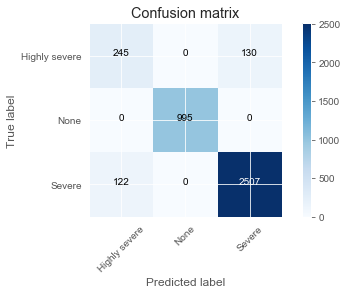

In [31]:
print('Accuracy of LogisticRegression with cv:'+str(cvscore2.mean()))
cm = metrics.confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

               precision    recall  f1-score   support

Highly severe       0.67      0.65      0.66       375
         None       1.00      1.00      1.00       995
       Severe       0.95      0.95      0.95      2629

     accuracy                           0.94      3999
    macro avg       0.87      0.87      0.87      3999
 weighted avg       0.94      0.94      0.94      3999



In [33]:
from sklearn.svm import LinearSVC
svmmodel= LinearSVC(C=1, multi_class='ovr', max_iter=10000, 
                        class_weight='balanced',penalty='l2' )
cvscore4=cross_val_score(svmmodel,X,np.ravel(y),cv=10)
y_pred=cross_val_predict(svmmodel,X,np.ravel(y),cv=10)
cvscore4,cvscore4.mean()

(array([0.945     , 0.86      , 0.8525    , 0.8925    , 0.9225    ,
        0.95      , 0.9625    , 0.985     , 0.9675    , 0.97994987]),
 0.9317449874686717)

Accuracy of SVM with cv:0.9317449874686717
Confusion matrix, without normalization


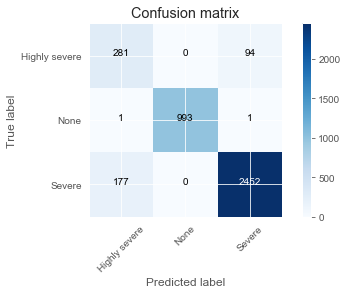

In [34]:
print('Accuracy of SVM with cv:'+str(cvscore4.mean()))
cm = metrics.confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [35]:
print(classification_report(y, y_pred))

               precision    recall  f1-score   support

Highly severe       0.61      0.75      0.67       375
         None       1.00      1.00      1.00       995
       Severe       0.96      0.93      0.95      2629

     accuracy                           0.93      3999
    macro avg       0.86      0.89      0.87      3999
 weighted avg       0.94      0.93      0.93      3999



In [36]:
from sklearn.ensemble import RandomForestClassifier
Random=RandomForestClassifier(n_estimators=400, n_jobs=4)
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
cvscore6=cross_val_score(Random,X,np.ravel(y),cv=10)
y_pred=cross_val_predict(Random,X,np.ravel(y),cv=10)
cvscore6,cvscore6.mean()

(array([0.91      , 0.9175    , 0.92      , 0.93      , 0.93      ,
        0.955     , 0.95      , 0.93      , 0.9575    , 0.96491228]),
 0.9364912280701756)

Accuracy of RF with cv:0.9364912280701756
Confusion matrix, without normalization


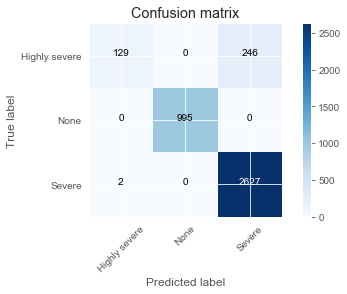

In [37]:

print('Accuracy of RF with cv:'+str(cvscore6.mean()))
cm = metrics.confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [38]:
print(classification_report(y, y_pred))

               precision    recall  f1-score   support

Highly severe       0.98      0.34      0.51       375
         None       1.00      1.00      1.00       995
       Severe       0.91      1.00      0.95      2629

     accuracy                           0.94      3999
    macro avg       0.97      0.78      0.82      3999
 weighted avg       0.94      0.94      0.92      3999



In [39]:
nb_model = GaussianNB()
cvscore8=cross_val_score(nb_model,X,np.ravel(y),cv=10)
y_pred=cross_val_predict(nb_model,X,np.ravel(y),cv=10)
cvscore8,cvscore8.mean()

(array([0.9325    , 0.865     , 0.8675    , 0.775     , 0.9325    ,
        0.94      , 0.9525    , 0.9725    , 0.89      , 0.96491228]),
 0.9092412280701756)

Accuracy of NB with cv:0.9092412280701756
Confusion matrix, without normalization


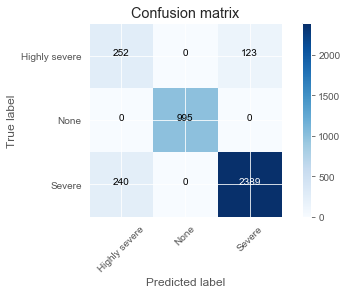

In [40]:
print('Accuracy of NB with cv:'+str(cvscore8.mean()))
cm = metrics.confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [41]:
print(classification_report(y, y_pred))

               precision    recall  f1-score   support

Highly severe       0.51      0.67      0.58       375
         None       1.00      1.00      1.00       995
       Severe       0.95      0.91      0.93      2629

     accuracy                           0.91      3999
    macro avg       0.82      0.86      0.84      3999
 weighted avg       0.92      0.91      0.91      3999

